In [1]:
#!/usr/bin/env python3
import cv2
import csv
import glob
import time
import imutils
import numpy as np
import mediapipe as mp
import mp_utils as mu
from matplotlib import pyplot as plt
from imutils.object_detection import non_max_suppression

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

ModuleNotFoundError: No module named 'mp_utils'

##### Mediapipe Pose - video files

In [ ]:
videos = glob.glob(".\\video\\*.*") 
#videos = ['.\\video\\walk3.mp4']
output_dir = ".\output\\"
print(len(videos))
for fullname in videos:
    print(fullname)

0


In [ ]:
def drawRef(frame, start, frameCount, width, height) :
    global refX, refY, mouseX, mouseY, font
    margin = 100
    seconds = time.time() - start
    fps  = frameCount / seconds
    msg = "fps{:.2f}".format(fps) + " - {0}".format(frameCount)+ "/{:.2f}".format(seconds)+ " - ({0},{1})".format(mouseX, mouseY)
    cv2.putText(frame, msg, (10, 30), font, 0.6, (255,0,0), 1, cv2.LINE_AA)
    color = (255, 0, 255)
    thickness = 3
    for x in refX:
        cv2.line(frame, (x, margin), (x, height-margin), color, thickness)
    for y in refY:
        cv2.line(frame, (margin, y), (width-margin, y), color, thickness)


def mouse_callback(event, x, y, flags, param): 
    global mouseX, mouseY
    mouseX, mouseY = x, y
    

In [ ]:
margin = 400
save_skeleton = True
debug_skeleton = True
mouseX, mouseY = 0, 0
refX = []#330, 550, 625
refY = [563] #100, 200, 300
font = cv2.FONT_HERSHEY_SIMPLEX
fourcc = cv2.VideoWriter_fourcc(*'XVID')

cv2.namedWindow("skeleton", cv2.WINDOW_NORMAL)  
cv2.setMouseCallback("skeleton", mouse_callback)
print("Mediapipe pos video files debug_skeleton : {0}".format(debug_skeleton))

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for fullname in videos:
        list = fullname.split('\\')
        output = output_dir+"skl_"+list[2]
        outputcsv = output_dir+list[2].split('.')[0]+'.csv'

        cap = cv2.VideoCapture(fullname)
        fps = cap.get(cv2.CAP_PROP_FPS)
        start = time.time()

        # get vcap property 
        width  = int(cap.get(3))   # float `width`
        height = int(cap.get(4))  # float `height`

        # it gives me 0.0 :/
        fps = int(cap.get(5))
        fp_count = int(cap.get(7))
        delay_time = int(1000/fps)

        if save_skeleton:
            out = cv2.VideoWriter(output, fourcc, fps, (width+margin, height))
            csvfile = open(outputcsv, "wt", newline='', encoding='utf-8')
            writer = csv.writer(csvfile)
            jointlist = []
            jointlist.extend(['frameCount', 'id'])
            for plm in mp_pose.PoseLandmark:
                jointlist.extend(['x '+str(plm), 'y '+str(plm), 'z '+str(plm), 'viz '+str(plm)])
            writer.writerow(jointlist)

        cv2.resizeWindow("skeleton", width+margin, height)  
        print(output, width, height, fp_count, fps)

        frameCount = 0
        while(cap.isOpened()):
            ret, frame = cap.read()
            if not ret:
                break

            frameCount += 1
            # To improve performance, optionally mark the image as not writeable to pass by reference.
            frame.flags.writeable = False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            blank_image = np.zeros((height, width+margin, 3), np.uint8)
            results = pose.process(frame)

            if not results.pose_landmarks:
              continue

            frame.flags.writeable = True
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            if save_skeleton:
                mu.writePoseLandmark(writer, mp_pose, results, frameCount)
            if debug_skeleton:
                mu.printPoseLandmark(blank_image, mp_pose, results, width, height)

            # Flip the image horizontally for a selfie-view display.
            # frame = cv2.flip(frame, 1)            
            drawRef(frame, start, frameCount, width, height)

            blank_image[:,0:width]=frame
            cv2.imshow('skeleton', blank_image)
            if save_skeleton:
                out.write(blank_image)

            key = cv2.waitKey(delay_time) & 0xFF
            if key == ord('q') or key == 27:
                break

        if save_skeleton:
            out.release()    
            csvfile.close()
        cap.release()
    cv2.destroyAllWindows()

Mediapipe pos video files debug_skeleton : True


NameError: name 'mp_pose' is not defined

##### 컴퓨터에 연결된 카메라의 index 값 확인 

In [5]:
out = mu.cameraIndexes(3)
print(out)

NameError: name 'mu' is not defined

##### Mediapipe Pose - camera - "q" or esc key 를 누르면 종료 합니다.

In [6]:
width, height, margin = 640, 480, 400
cap, fps = mu.setCamera(0, width, height)

display_scale = 1
title = "Media Pose"
mu.setCVWindows(title, display_scale, margin)

save_skeleton = True
debug_skeleton = True
if save_skeleton:
  output_dir = ".\output\\"
  out, skl = mu.setSaveSkeleton(output_dir)
  csv, writer =  mu.setSavePose(output_dir, mp_pose)

frameCount = 0
start = time.time()
delay_time = int(1000/fps)
font = cv2.FONT_HERSHEY_SIMPLEX

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, frame = cap.read()
    if not success:
      continue
    frameCount += 1

    # Flip the image horizontally for a selfie-view display.
    frame = cv2.flip(frame, 1)
    if save_skeleton:
      out.write(frame)

    # To improve performance, optionally mark the image as not writeable to pass by reference.
    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame)
    blank_image = np.zeros((height, width+margin, 3), np.uint8)

    if not results.pose_landmarks:
      continue
    if save_skeleton:
      mu.writePoseLandmark(writer, mp_pose, results, frameCount)
    if debug_skeleton:
      mu.printPoseLandmark(blank_image, mp_pose, results, width, height)

    # # Draw segmentation on the image.
    # # To improve segmentation around boundaries, consider applying a joint
    # # bilateral filter to "results.segmentation_mask" with "image".
    # annotated_frame = frame.copy()
    # condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    # bg_frame = np.zeros(frame.shape, dtype=np.uint8)
    # bg_frame[:] = BG_COLOR
    # annotated_frame = np.where(condition, annotated_frame, bg_frame)
    # # Draw pose landmarks on the frame.
    # mp_drawing.draw_landmarks(annotated_frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
    #   landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    # Draw the pose annotation on the image.
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    mu.debugFrameMessage(frame, font, frameCount, start, 0)
    blank_image[:,0:width]=frame
    cv2.imshow(title, blank_image)
    if save_skeleton:
      skl.write(frame)
 
    key = cv2.waitKey(delay_time) & 0xFF
    if key == ord('q') or key == 27:
      break
    elif key == ord(' '):
      frameCount = 0
  if save_skeleton:
    mu.closeSkeleton(out, skl, csv)
  cap.release()
cv2.destroyAllWindows()

NameError: name 'mu' is not defined

##### MediaPipe Pose - image files

In [2]:
# For static images:
files = glob.glob(".\\image\\*.jpg") 
output_dir = ".\output\\"
print(len(files))
for filename in files:
  print(filename)

0


In [7]:
print_skeleton = False
display_skeleton = True
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(static_image_mode=True, model_complexity=2,
  enable_segmentation=True, min_detection_confidence=0.5) as pose:
  for idx, file in enumerate(files):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    if not results.pose_landmarks:
      continue

    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    annotated_image = image.copy()
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)

    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    if print_skeleton:
      mu.print_landmark(mp_pose, results.pose_landmarks.landmark, image.shape)

    if display_skeleton:
      plt.figure(figsize = (10,7))
      plt.subplot(1,2,1), plt.imshow(image)
      plt.title('Origin'), plt.xticks([]), plt.yticks([])
      plt.subplot(1,2,2), plt.imshow(annotated_image)
      plt.title('Skeleton'), plt.xticks([]), plt.yticks([])
      plt.show()

    # Plot pose world landmarks.
    # mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    list = file.split('\\')[2].split('.')
    output = output_dir+'out_'+list[0]+'.jpg'
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output, annotated_image)


NameError: name 'mp_pose' is not defined

##### Mediapipe Hand - camera

In [ ]:
width, height = 640, 480
cap, fps = mu.setCamera(0, width, height)

display_scale = 1
title = "Media Hand"
mu.setCVWindows(title, display_scale, 0)

save_skeleton = True
debug_skeleton = False
if save_skeleton:
  output_dir = ".\output\\"
  out, skl = mu.setSaveSkeleton(output_dir)
  csv, writer =  mu.setSaveHands(output_dir, mp_hands)

frameCount = 0
start = time.time()
delay_time = int(1000/fps)
font = cv2.FONT_HERSHEY_SIMPLEX

with mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, frame = cap.read()
    if not success:
      continue

    frameCount += 1
    # Flip the image horizontally for a selfie-view display.
    frame = cv2.flip(frame, 1)
    if save_skeleton:
      out.write(frame)

    # To improve performance, optionally mark the image as not writeable to pass by reference.
    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame)

    if not results.multi_hand_landmarks:
      continue

    if save_skeleton:
      mu.writeHandsLandmark(writer, mp_hands, results, frameCount)
    if debug_skeleton:
      mu.printHandsLandmark(mp_hands, results)

    # Draw the pose annotation on the image.
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    for hand_landmarks in results.multi_hand_landmarks:
      mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(), mp_drawing_styles.get_default_hand_connections_style())

    mu.debugFrameMessage(frame, font, frameCount, start, 0)
    cv2.imshow(title, frame)
    if save_skeleton:
      skl.write(frame)

    key = cv2.waitKey(delay_time) & 0xFF
    if key == ord('q') or key == 27:
      break
  if save_skeleton:
    mu.closeSkeleton(out, skl, csv)
  cap.release()
cv2.destroyAllWindows()

fps using camera id = 0  : 30
.\output\video_202408011355.mp4
.\output\skeleton_202408011355.mp4
.\output\skeleton_202408011355.csv


##### Mediapipe Face - camera

In [ ]:
width, height = 640, 480
cap, fps = mu.setCamera(0, width, height)

display_scale = 1
title = "Media Face"
mu.setCVWindows(title, display_scale, 0)

save_skeleton = True
debug_skeleton = False
if save_skeleton:
  output_dir = ".\output\\"
  out, skl = mu.setSaveSkeleton(output_dir)
  csv, writer =  mu.setSaveFaces(output_dir, 478)

frameCount = 0
start = time.time()
delay_time = int(1000/fps)
font = cv2.FONT_HERSHEY_SIMPLEX

with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, 
  refine_landmarks=True, min_detection_confidence=0.5) as face_mesh:  
  while cap.isOpened():
    success, frame = cap.read()
    if not success:
      continue

    frameCount += 1
    # Flip the image horizontally for a selfie-view display.
    frame = cv2.flip(frame, 1)
    if save_skeleton:
      out.write(frame)

    # To improve performance, optionally mark the image as not writeable to pass by reference.
    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(frame)

    if not results.multi_face_landmarks:
      continue

    if save_skeleton:
      mu.writeFacesLandmark(writer, results, frameCount)
    if debug_skeleton:
      mu.printFacesLandmark(results)

    # Draw the pose annotation on the image.
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(image=frame, landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_TESSELATION, landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(image=frame, landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_CONTOURS, landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
      mp_drawing.draw_landmarks(image=frame, landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_IRISES, landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style())

    mu.debugFrameMessage(frame, font, frameCount, start, 0)
    cv2.imshow(title, frame)
    if save_skeleton:
      skl.write(frame)

    key = cv2.waitKey(delay_time) & 0xFF
    if key == ord('q') or key == 27:
      break
  if save_skeleton:
    mu.closeSkeleton(out, skl, csv)
  cap.release()
cv2.destroyAllWindows()

fps using camera id = 0  : 30
.\output\video_202408011356.mp4
.\output\skeleton_202408011356.mp4
.\output\skeleton_202408011356.csv


##### Mediapipe Holistic - camera

In [ ]:
# For webcam input:
fps = 25
camId = 0
width = 640
height = 480
frameCount = 0

debug_skeleton = False
display_skeleton = True

display_scale = 1
dwidth = int(width/display_scale)
dheight = int(height/display_scale)

stime = time.strftime('%Y%m%d%H%M', time.localtime())
output_dir = ".\output\\"
outputvideo = output_dir + "video_" + stime + ".mp4" 
skeletonvideo = output_dir + "skeleton_" + stime + ".mp4"
outputcsv = output_dir + "skeleton_" + stime + ".csv"

cap = cv2.VideoCapture(camId)
cap.set(cv2.CAP_PROP_FPS, fps)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
font = cv2.FONT_HERSHEY_SIMPLEX
fps = cap.get(cv2.CAP_PROP_FPS)
print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
start = time.time()
delay_time = int(1000/fps)
cv2.namedWindow("skeleton", cv2.WINDOW_NORMAL)        
cv2.resizeWindow("skeleton", dwidth, dheight)  

if debug_skeleton:
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(outputvideo, fourcc, fps, (width, height))
  skl = cv2.VideoWriter(skeletonvideo, fourcc, fps, (width, height))
  csv, writer = mu.save_csv(outputcsv, mp_pose)

with mp_holistic.Holistic(static_image_mode=True, model_complexity=2,
  enable_segmentation=True, refine_face_landmarks=True) as holistic:
  while cap.isOpened():
    success, frame = cap.read()
    if not success:
      continue

    frameCount += 1
    # Flip the image horizontally for a selfie-view display.
    frame = cv2.flip(frame, 1)
    if debug_skeleton:
      out.write(frame)

    # To improve performance, optionally mark the image as not writeable to pass by reference.
    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(frame)

    if not results.pose_landmarks:
      continue

    if debug_skeleton:
      mu.write_landmark(writer, mp_pose, results.pose_landmarks.landmark, frame.shape, frameCount)
    # mu.print_landmark(results.pose_landmarks.landmark, image.shape)

    # Draw the pose annotation on the image.
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    mp_drawing.draw_landmarks(frame, results.face_landmarks,
      mp_holistic.FACEMESH_TESSELATION, landmark_drawing_spec=None,
      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
      landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS)

    seconds = time.time() - start
    fps  = frameCount / seconds
    msg = "fps{:.2f}".format(fps) + " - {0}".format(frameCount)+ "/{:.2f}".format(seconds)
    cv2.putText(frame, msg, (10, 30), font, 0.6, (255,0,0), 1, cv2.LINE_AA)
    if debug_skeleton:
      skl.write(frame)
    cv2.imshow('skeleton', frame)

    key = cv2.waitKey(delay_time) & 0xFF
    if key == ord('q') or key == 27:
      break
  if debug_skeleton:
    csv.close()
    out.release()    
    skl.release()    
  cap.release()
  cv2.destroyAllWindows()


Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.0


##### OpenCV HOGD Detection - image files

In [ ]:
# For static images:
files = glob.glob(".\\image\\*.jpg") 
output_dir = ".\output\\"
print(len(files))
for filename in files:
  print(filename)

5
.\image\00047.jpg
.\image\00049.jpg
.\image\00101.jpg
.\image\persons0.jpg
.\image\persons1.jpg


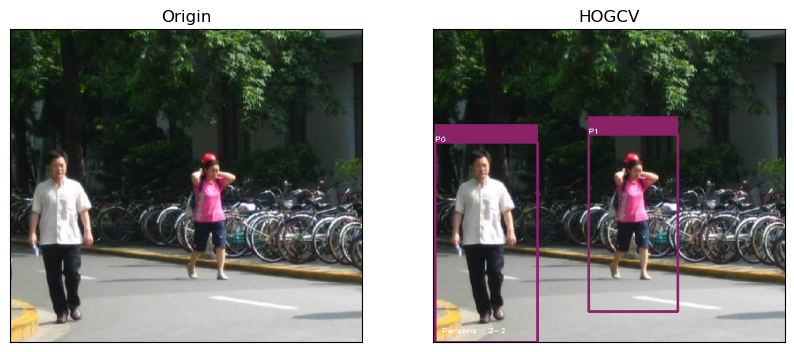

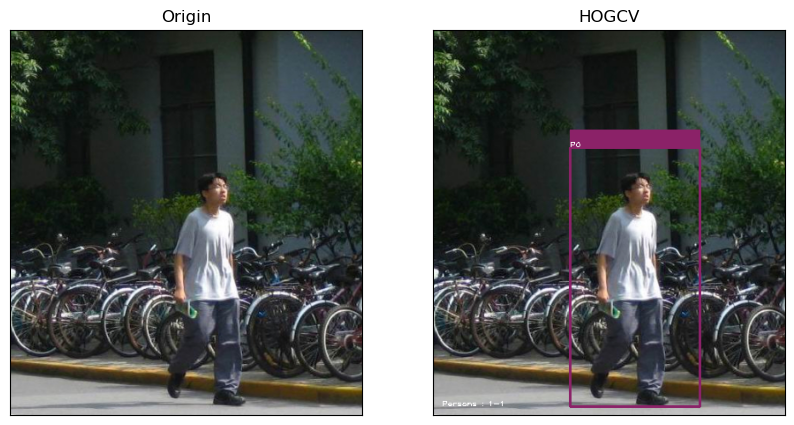

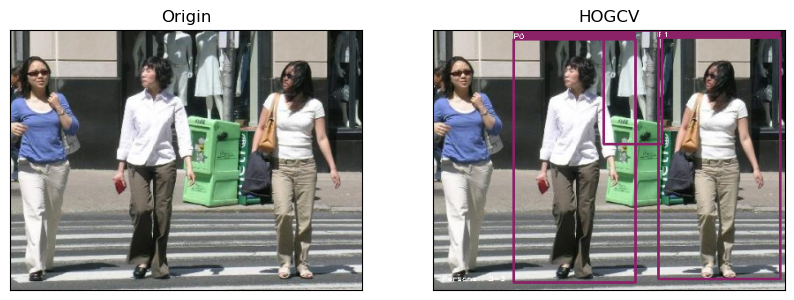

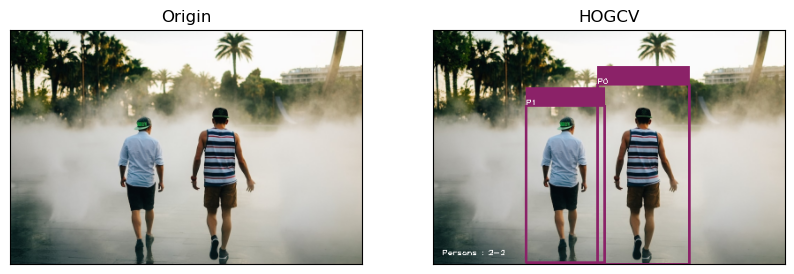

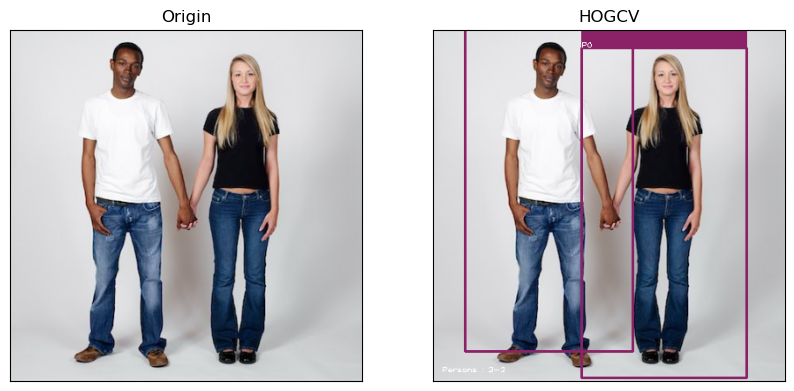

In [ ]:
## Histogram of Oriented Gradients Detector
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
font = cv2.FONT_HERSHEY_PLAIN
display_skeleton = 1

for idx, file in enumerate(files):
    image = cv2.imread(file)
    image = imutils.resize(image, width=min(400, image.shape[1]))

    # Convert the BGR image to RGB before processing.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated_image = image.copy()
    height, width, _ = image.shape
  
    rects, weights = HOGCV.detectMultiScale(image, winStride=(4, 4), padding=(8, 8), scale=1.05)    

	# apply non-maxima suppression to the bounding boxes using a fairly large overlap threshold 
    # to try to maintain overlapping boxes that are still people
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

	# draw the final bounding boxes
    c = 0
    for x, y, w, h in pick:
        cv2.rectangle(annotated_image, (x, y), (w, h), (139, 34, 104), 2)
        cv2.rectangle(annotated_image, (x, y - 20), (w,y), (139, 34, 104), -1)
        cv2.putText(annotated_image, f'P{c}', (x, y), font, 0.6, (255, 255, 255), 1)
        c += 1

    cv2.putText(annotated_image, f'Persons : {len(rects)}-{len(pick)}', (10, height-10), font, 0.6, (255, 255,255), 1) 

    if display_skeleton:
        plt.figure(figsize = (10,7))
        plt.subplot(1,2,1), plt.imshow(image)
        plt.title('Origin'), plt.xticks([]), plt.yticks([])
        plt.subplot(1,2,2), plt.imshow(annotated_image)
        plt.title('HOGCV'), plt.xticks([]), plt.yticks([])
        plt.show()

    list = file.split('\\')[2].split('.')
    output = output_dir+'hog_'+list[0]+'.jpg'
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(output, annotated_image)

##### OpenCV HOGD Detection - camera

In [ ]:
width, height = 640, 480
#width, height = 1920, 1080
cap, fps = mu.setCamera(0, width, height)

display_scale = 1
title = "HOGCV"
mu.setCVWindows(title, display_scale, 0)

save_skeleton = False
if save_skeleton:
  output_dir = ".\output\\"
  stime = time.strftime('%Y%m%d%H%M', time.localtime())
  outputvideo = output_dir + "video_" + stime + ".mp4" 
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(outputvideo, fourcc, fps, (width, height))

## Histogram of Oriented Gradients Detector
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# https://thedatafrog.com/en/articles/human-detection-video/
# https://debuggercafe.com/opencv-hog-hyperparameter-tuning-for-accurate-and-fast-person-detection/

frameCount = 0
start = time.time()
delay_time = int(1000/fps)
font = cv2.FONT_HERSHEY_SIMPLEX

while cap.isOpened():
  success, frame = cap.read()
  if not success:
    continue

  frameCount += 1
  frame = cv2.flip(frame, 1)
  # Convert the BGR image to RGB before processing.
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  frame = imutils.resize(frame, width=min(640, image.shape[1]))
  rects, weights = HOGCV.detectMultiScale(frame, winStride=(4, 4), padding=(8, 8), scale=1.05)  
  
  # apply non-maxima suppression to the bounding boxes using a fairly large overlap threshold 
  # to try to maintain overlapping boxes that are still people
  rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
  pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

  # Convert the BGR image to RGB before processing.
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  # draw the final bounding boxes
  c = 0
  for x, y, w, h in pick:
    cv2.rectangle(frame, (x, y), (w, h), (139, 34, 104), 2)
    cv2.rectangle(frame, (x, y - 20), (w,y), (139, 34, 104), -1)
    cv2.putText(frame, f'P{c}', (x, y), font, 0.6, (255, 255, 255), 1)
    c += 1

  cv2.putText(frame, f'Persons : {len(rects)}-{len(pick)}', (10, height-10), font, 0.6, (255, 255,255), 1) 

  mu.debugFrameMessage(frame, font, frameCount, start, 0)
  cv2.imshow(title, frame)
  if save_skeleton:
    out.write(frame)

  key = cv2.waitKey(delay_time) & 0xFF
  if key == ord('q') or key == 27:
    break
if save_skeleton:  
  out.release()    
cap.release()
cv2.destroyAllWindows()

fps using camera id = 0  : 30


##### Mediapipe pose with OpenCV HOGD - image files - Multiperson skeleton Detection

In [ ]:
# For static images:
files = glob.glob(".\\image\\*.jpg") 
output_dir = ".\output\\"
print(len(files))
for filename in files:
  print(filename)

5
.\image\00047.jpg
.\image\00049.jpg
.\image\00101.jpg
.\image\persons0.jpg
.\image\persons1.jpg


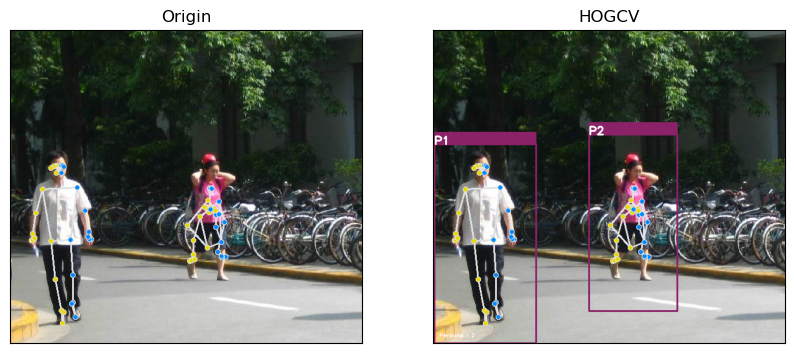

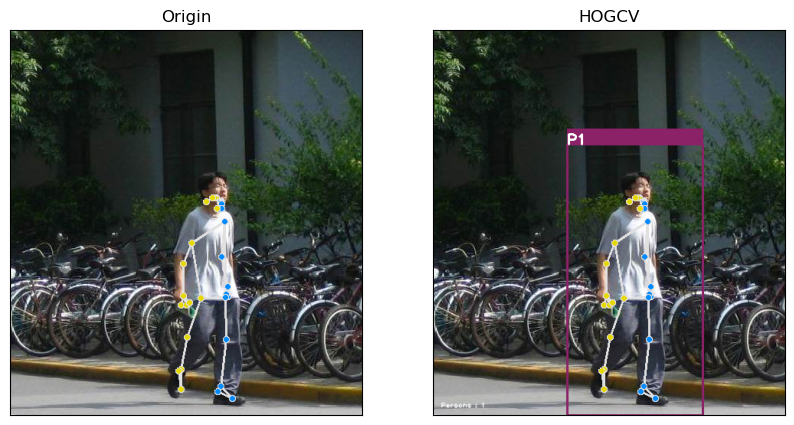

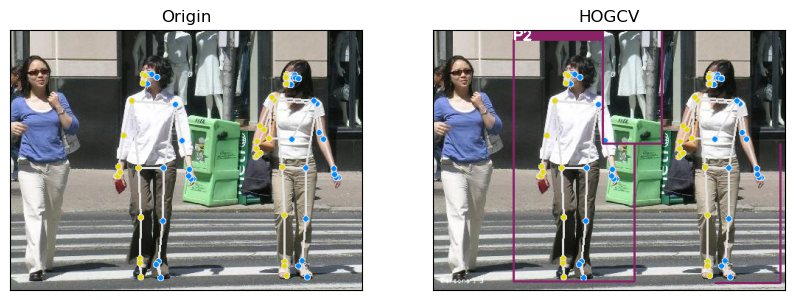

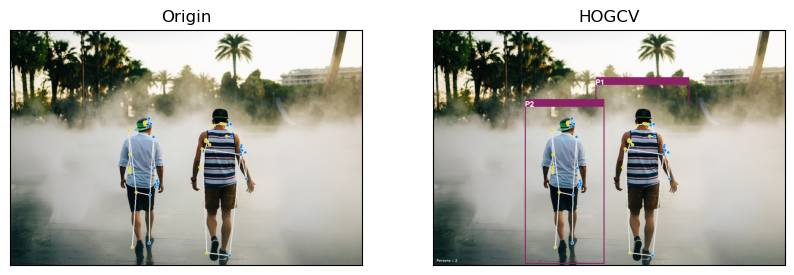

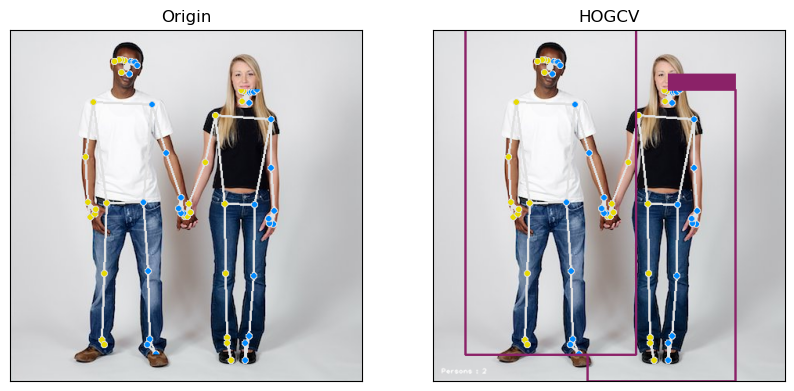

In [ ]:
## Histogram of Oriented Gradients Detector
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
font = cv2.FONT_HERSHEY_PLAIN
debug_skeleton = False

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
  for idx, file in enumerate(files):
    image = cv2.imread(file)

    # Convert the BGR image to RGB before processing.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # frame = imutils.resize(frame, width=min(400, frame.shape[1]))
    debug = image.copy()
    height, width, _ = image.shape

    ## USing Sliding window concept
    rects, weights = HOGCV.detectMultiScale(image, winStride=(4, 4), padding=(8, 8), scale=1.03)    
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

    c = 1
    for x, y, w, h in pick:
      crop = image[y:y+h, x:x+w]
      results = pose.process(crop)

      if not results.pose_landmarks:
        continue
      
      if debug_skeleton:
        mu.printPoseLandmark(mp_pose, results)

      mp_drawing.draw_landmarks(crop, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      debug[y:y+h, x:x+w] = crop

      cv2.rectangle(debug, (x, y), (w, h), (139, 34, 104), 2)
      cv2.rectangle(debug, (x, y - 20), (w,y), (139, 34, 104), -1)
      cv2.putText(debug, f'P{c}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
      c += 1
          
    cv2.putText(debug, f'Persons : {c - 1}', (10, height-10), font, 0.6, (255, 255,255), 1, cv2.LINE_AA)

    if display_skeleton:
      plt.figure(figsize = (10,7))
      plt.subplot(1,2,1), plt.imshow(image)
      plt.title('Origin'), plt.xticks([]), plt.yticks([])
      plt.subplot(1,2,2), plt.imshow(debug)
      plt.title('HOGCV'), plt.xticks([]), plt.yticks([])
      plt.show()

    list = file.split('\\')[2].split('.')
    output = output_dir+'hog_'+list[0]+'.jpg'
    debug = cv2.cvtColor(debug, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output, debug)

##### Mediapipe pose with OpenCV HOGD - camera - Multiperson skeleton Detection

In [ ]:
width, height = 640, 480
cap, fps = mu.setCamera(0, width, height)

display_scale = 1
title = "Media Pose with HOGD"
mu.setCVWindows(title, display_scale, 0)

save_skeleton = True
debug_skeleton = False
if save_skeleton:
  output_dir = ".\output\\"
  out, skl = mu.setSaveSkeleton(output_dir)
  csv, writer =  mu.setSavePose(output_dir, mp_pose)

frameCount = 0
start = time.time()
delay_time = int(1000/fps)
font = cv2.FONT_HERSHEY_SIMPLEX

## Histogram of Oriented Gradients Detector
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, frame = cap.read()
    if not success:
      continue

    frame = cv2.flip(frame, 1)
    out.write(frame)

    # To improve performance, optionally mark the image as not writeable to pass by reference.
    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    ## USing Sliding window concept
    rects, weights = HOGCV.detectMultiScale(frame, winStride=(4, 4), padding=(8, 8), scale=1.03)    
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = imutils.object_detection.non_max_suppression(rects, probs=None, overlapThresh=0.65)

    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    c = 1
    for x, y, w, h in pick:
      crop = frame[y:y+h, x:x+w]
      results = pose.process(crop)

      if not results.pose_landmarks:
        continue
      
      if save_skeleton:
        mu.writePoseLandmark(writer, mp_pose, results, frameCount)
      
      if debug_skeleton:
        mu.printPoseLandmark(mp_pose, results)

      mp_drawing.draw_landmarks(crop, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      frame[y:y+h, x:x+w] = crop

      cv2.rectangle(frame, (x, y), (w, h), (139, 34, 104), 2)
      cv2.rectangle(frame, (x, y - 20), (w,y), (139, 34, 104), -1)
      cv2.putText(frame, f'P{c}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
      c += 1
        
    cv2.putText(frame, f'Persons : {c - 1}', (10, height-10), font, 0.6, (255, 255,255), 1, cv2.LINE_AA)
    mu.debugFrameMessage(frame, font, frameCount, start, 0)
    cv2.imshow(title, frame)
    if save_skeleton:
      skl.write(frame)
 
    key = cv2.waitKey(delay_time) & 0xFF
    if key == ord('q') or key == 27:
      break
  
  if save_skeleton:
    mu.closeSkeleton(out, skl, csv)
  cap.release()
cv2.destroyAllWindows()

fps using camera id = 0  : 30
.\output\video_202408011401.mp4
.\output\skeleton_202408011401.mp4
.\output\skeleton_202408011401.csv


##### YOLO Object Detection - image files - 320, 416, 608

In [ ]:
# For static images:
files = glob.glob(".\\image\\*.jpg") 
output_dir = ".\output\\"
print(len(files))
for filename in files:
  print(filename)

5
.\image\00047.jpg
.\image\00049.jpg
.\image\00101.jpg
.\image\persons0.jpg
.\image\persons1.jpg


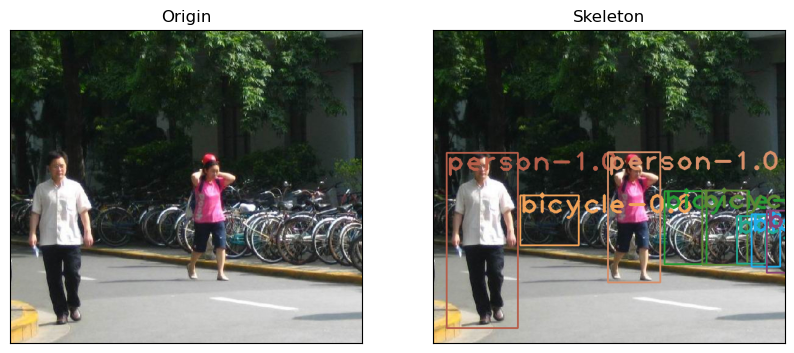

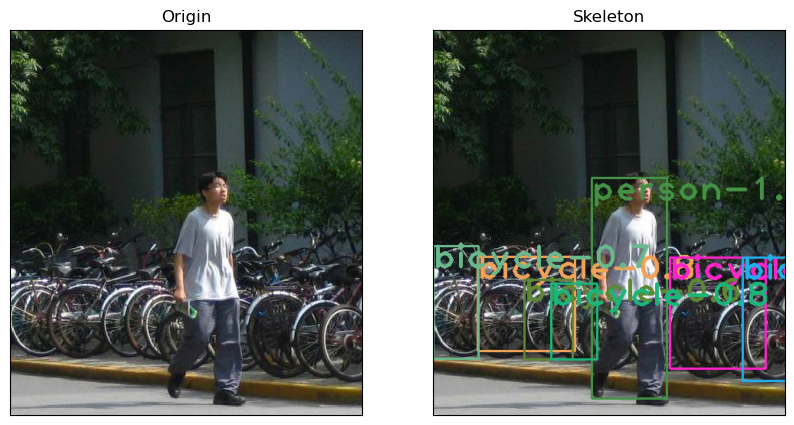

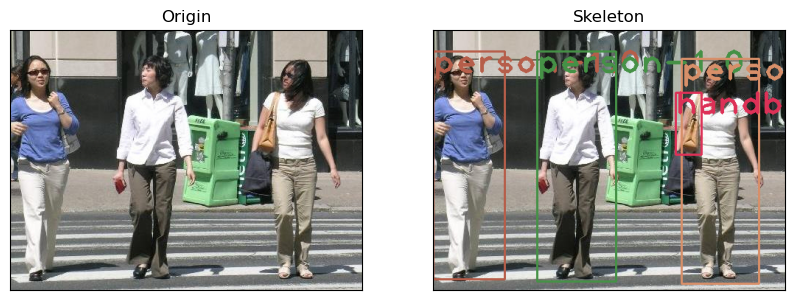

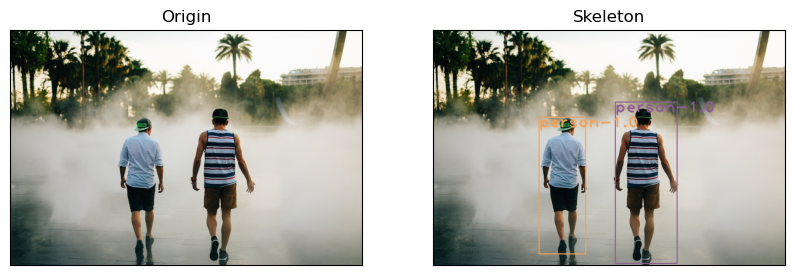

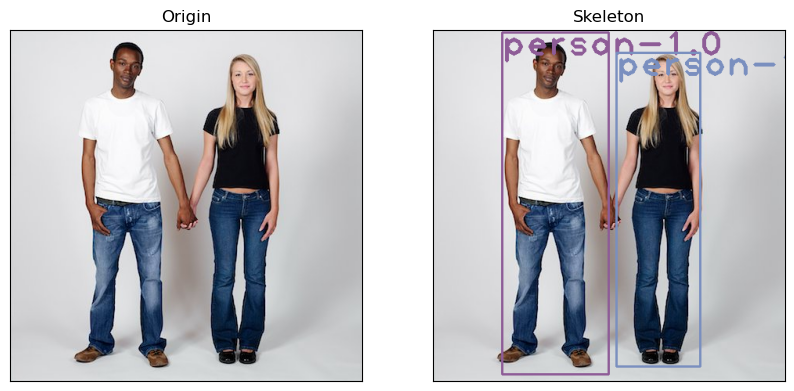

In [ ]:
# Yolo 로드
net = cv2.dnn.readNet("yolo3/yolov3.weights", "yolo3/yolov3.cfg")
# https://pjreddie.com/darknet/yolo/
# https://github.com/pjreddie/darknet/blob/master/data/coco.names
classes = []
with open("yolo3/coco.names", "r") as f:
  classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

font = cv2.FONT_HERSHEY_PLAIN
display_skeleton = 1

for idx, file in enumerate(files):
  image = cv2.imread(file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  annotated_image = image.copy()

  height, width, _ = image.shape
  # Convert the BGR image to RGB before processing.

  # Detecting objects
  blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(output_layers)

  # 정보를 화면에 표시
  class_ids = []
  confidences = []
  boxes = []
  for out in outs:
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      if confidence > 0.5:
        # Object detected
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        w = int(detection[2] * width)
        h = int(detection[3] * height)
        # 좌표
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)
        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  for i in range(len(boxes)):
    if i in indexes:
      x, y, w, h = boxes[i]
      label = "%s-%3.1f" % (classes[class_ids[i]], confidences[i])
      color = colors[i]
      cv2.rectangle(annotated_image, (x, y), (x + w, y + h), color, 2)
      cv2.putText(annotated_image, label, (x, y + 30), font, 3, color, 3)

  if display_skeleton:
    plt.figure(figsize = (10,7))
    plt.subplot(1,2,1), plt.imshow(image)
    plt.title('Origin'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2), plt.imshow(annotated_image)
    plt.title('Skeleton'), plt.xticks([]), plt.yticks([])
    plt.show()

  list = file.split('\\')[2].split('.')
  output = output_dir+'obj_'+list[0]+'.jpg'
  annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
  
  cv2.imwrite(output, annotated_image)

##### YOLO Object Detection - camera - 320, 416, 608

In [ ]:
width, height = 640, 480
# width, height = 1920, 1080
cap, fps = mu.setCamera(0, width, height)

display_scale = 1
title = "Yolo v3"
mu.setCVWindows(title, display_scale, 0)

save_skeleton = False
if save_skeleton:
    output_dir = ".\output\\"
    stime = time.strftime('%Y%m%d%H%M', time.localtime())
    outputvideo = output_dir + "video_" + stime + ".mp4" 
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(outputvideo, fourcc, fps, (width, height))

frameCount = 0
start = time.time()
delay_time = int(1000/fps)
font = cv2.FONT_HERSHEY_SIMPLEX

# Yolo 로드
net = cv2.dnn.readNet("yolo3/yolov3.weights", "yolo3/yolov3.cfg")
classes = []
with open("yolo3/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

while cap.isOpened():
    success, frame = cap.read()
    if not success:
      continue

    frameCount += 1
    frame = cv2.flip(frame, 1)
    height, width, _ = frame.shape
    # Convert the BGR image to RGB before processing.
  
    # Detecting objects
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # 정보를 화면에 표시
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # 좌표
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = "%s-%3.1f" % (classes[class_ids[i]], confidences[i])
            color = colors[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y + 30), font, 3, color, 3)

    # Flip the image horizontally for a selfie-view display.
    seconds = time.time() - start
    fps  = frameCount / seconds
    msg = "fps{:.2f}".format(fps) + " - {0}".format(frameCount)+ "/{:.2f}".format(seconds)
    cv2.putText(frame, msg, (10, 30), font, 0.6, (255,0,0), 1, cv2.LINE_AA)
    cv2.imshow(title, frame)
    if save_skeleton:
        out.write(frame)

    key = cv2.waitKey(delay_time) & 0xFF
    if key == ord('q') or key == 27:
        break
if save_skeleton:  
    out.release()    
cap.release()
cv2.destroyAllWindows()

fps using camera id = 0  : 30


##### SSD Object Detection - image

In [ ]:
cv_net = cv2.dnn.readNetFromTensorflow('ssd/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb', 
  'ssd/ssd_inception_v2_coco_2017_11_17.pbtxt')
# cv_net_mobile = cv2.dnn.readNetFromTensorflow('./pretrained/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb', 
#  './pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt')
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
  11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
  21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
  31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
  41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
  51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
  61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
  71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
  81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
  91:'hair brush'}

image shape: (516, 580, 3)
(1, 1, 100, 7)


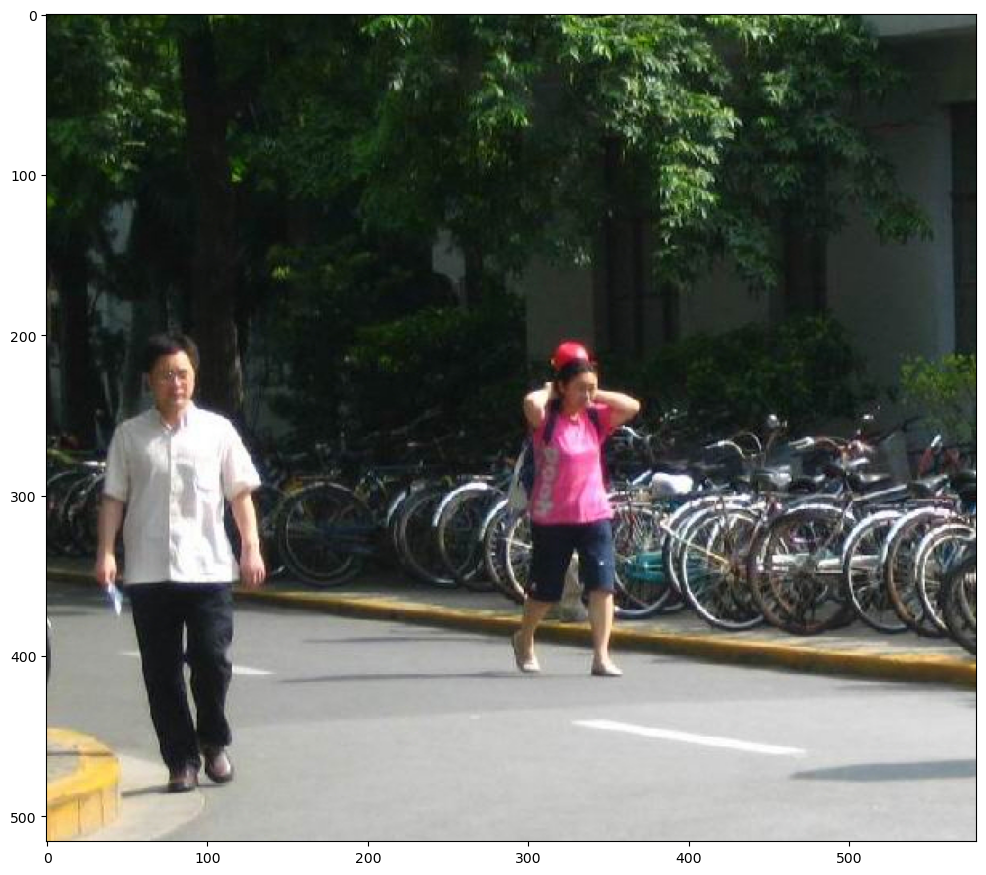

In [ ]:
img = cv2.imread('image/00047.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

# 원본 이미지 (633, 806)를 네트웍에 입력시에는 (300, 300)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# 원본 이미지 배열을 사이즈 (300, 300)으로, BGR을 RGB로 변환하여 배열 입력
cv_net.setInput(cv2.dnn.blobFromImage(img,  size=(300, 300), swapRB=True, crop=False))
# Object Detection 수행하여 결과를 cv_out으로 반환 
cv_out = cv_net.forward()
print(cv_out.shape)

(1, 1, 100, 7)
person: 0.9974 1
person: 0.9124 1
bicycle: 0.6175 2
bicycle: 0.5730 2
bicycle: 0.5126 2
motorcycle: 0.4948 4
motorcycle: 0.4864 4
bicycle: 0.4289 2
bicycle: 0.3972 2
bicycle: 0.3823 2
motorcycle: 0.3573 4
bicycle: 0.3481 2
bicycle: 0.3294 2


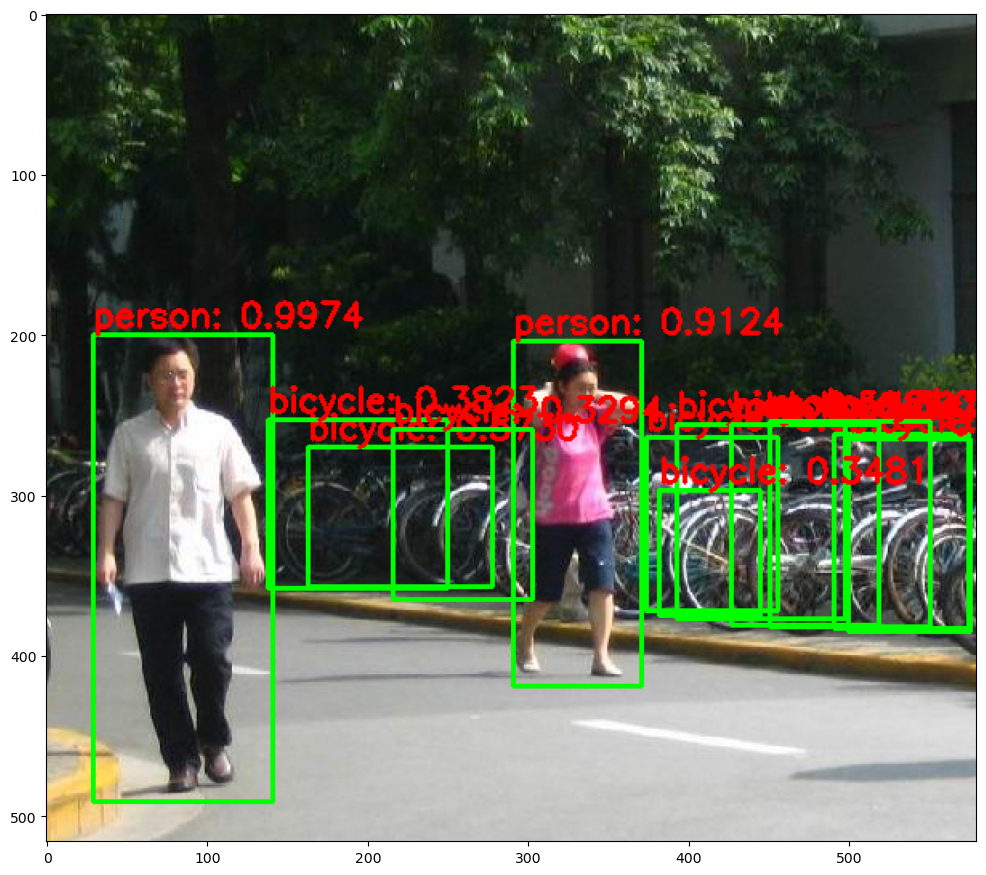

In [ ]:
# 원본 이미지 (633, 806)를 네트웍에 입력시에는 (300, 300)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# 원본 이미지 배열을 사이즈 (300, 300)으로, BGR을 RGB로 변환하여 배열 입력
cv_net.setInput(cv2.dnn.blobFromImage(img,  size=(300, 300), swapRB=True, crop=False))
# Object Detection 수행하여 결과를 cv_out으로 반환 
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.3 이상만 추출
    if score > 0.3:
        # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
        
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
        print(caption, class_id)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)